In [4]:
import pandas as pd

# Make sure the filename matches exactly what you uploaded
file_name = '/content/Fraud.csv'

print(f"Loading '{file_name}'...")
try:
    df = pd.read_csv(file_name)
    print("Dataset loaded successfully!")

    print("\n--- Initial Data Inspection ---")
    print("\nFirst 5 rows of the dataset:")
    print(df.head().to_markdown(index=False)) # Using to_markdown for easy copy-pasting

    print("\nDataset Information:")
    df.info()

    print("\nMissing Values Count:")
    print(df.isnull().sum().to_markdown()) # Using to_markdown for easy copy-pasting

except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found. Please ensure it is uploaded correctly to Colab's session storage and the filename matches.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Loading '/content/Fraud.csv'...
Dataset loaded successfully!

--- Initial Data Inspection ---

First 5 rows of the dataset:
|   step | type     |   amount | nameOrig    |   oldbalanceOrg |   newbalanceOrig | nameDest    |   oldbalanceDest |   newbalanceDest |   isFraud |   isFlaggedFraud |
|-------:|:---------|---------:|:------------|----------------:|-----------------:|:------------|-----------------:|-----------------:|----------:|-----------------:|
|      1 | PAYMENT  |  9839.64 | C1231006815 |          170136 |         160296   | M1979787155 |                0 |                0 |         0 |                0 |
|      1 | PAYMENT  |  1864.28 | C1666544295 |           21249 |          19384.7 | M2044282225 |                0 |                0 |         0 |                0 |
|      1 | TRANSFER |   181    | C1305486145 |             181 |              0   | C553264065  |                0 |                0 |         1 |                0 |
|      1 | CASH_OUT |   181    | C8400836

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("Libraries imported successfully.")

# --- Data Loading ---
try:
    df = pd.read_csv('/content/Fraud.csv')
    print("Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'fraud.csv' not found. Please ensure the file is uploaded to the current Colab session.")
    # For now, I'll proceed assuming it's uploaded. If not, the subsequent steps will fail.


# --- Initial Data Exploration ---

print("\n--- Initial Data Snapshot (First 5 rows) ---")
print(df.head())

print("\n--- Dataset Information (Data types, Non-null counts) ---")
df.info()

print("\n--- Descriptive Statistics for Numerical Columns ---")
print(df.describe())

print("\n--- Checking for Missing Values ---")
print(df.isnull().sum())

print("\n--- Class Distribution of Target Variable (isFraud) ---")
print(df['isFraud'].value_counts())
print(f"Fraudulent transactions: {df['isFraud'].value_counts()[1]} ({df['isFraud'].value_counts(normalize=True)[1]:.4f}%)")

print("\n--- Unique Transaction Types ---")
print(df['type'].value_counts())

print("\n--- Checking 'isFlaggedFraud' distribution ---")
print(df['isFlaggedFraud'].value_counts())

print("\n--- Exploring 'nameOrig' and 'nameDest' prefixes ---")
print(f"Unique 'nameOrig' prefixes: {df['nameOrig'].apply(lambda x: x[0]).unique()}")
print(f"Unique 'nameDest' prefixes: {df['nameDest'].apply(lambda x: x[0]).unique()}")

# Check if all 'M' transactions in nameDest have old/new balance as 0
merchants_dest_df = df[df['nameDest'].str.startswith('M')]
print("\n--- Descriptive statistics for oldbalanceDest and newbalanceDest for Merchant transactions (nameDest starts with 'M') ---")
print(merchants_dest_df[['oldbalanceDest', 'newbalanceDest']].describe())

# Checking if nameOrig starting with 'M' exists (shouldn't based on data dictionary, but good to confirm)
merchants_orig_df = df[df['nameOrig'].str.startswith('M')]
print("\n--- Checking for transactions where nameOrig starts with 'M' ---")
print(merchants_orig_df.shape[0])

Libraries imported successfully.
Dataset loaded successfully!
Dataset shape: (6362620, 11)

--- Initial Data Snapshot (First 5 rows) ---
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT  9839.640  C1231006815     170136.000      160296.360   
1     1   PAYMENT  1864.280  C1666544295      21249.000       19384.720   
2     1  TRANSFER   181.000  C1305486145        181.000           0.000   
3     1  CASH_OUT   181.000   C840083671        181.000           0.000   
4     1   PAYMENT 11668.140  C2048537720      41554.000       29885.860   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155           0.000           0.000        0               0  
1  M2044282225           0.000           0.000        0               0  
2   C553264065           0.000           0.000        1               0  
3    C38997010       21182.000           0.000        1               0  
4  M1230701703           0.000           0


--- Phase 2: Data Cleaning & Feature Engineering (Part 1) ---

--- Addressing Balance Inconsistencies & Specific Zero-Balance Patterns ---

--- Checking Newly Created Balance-Related Features ---

'orig_balance_error' descriptive statistics:
count    6362620.000
mean      201092.468
std       606650.460
min           -0.010
25%         2954.230
50%        68677.255
75%       249641.088
max     92445516.640
Name: orig_balance_error, dtype: float64

'dest_balance_error' descriptive statistics (for Customer Destinations only):
count     4211125.000
mean       -77285.625
std        541361.611
min     -13191233.980
25%       -136382.680
50%             0.000
75%             0.000
max      75885725.630
Name: dest_balance_error, dtype: float64

--- Distribution of 'orig_balance_error' for Fraudulent vs Non-Fraudulent Transactions ---
              count       mean        std    min      25%       50%  \
isFraud                                                               
0       6354407.00

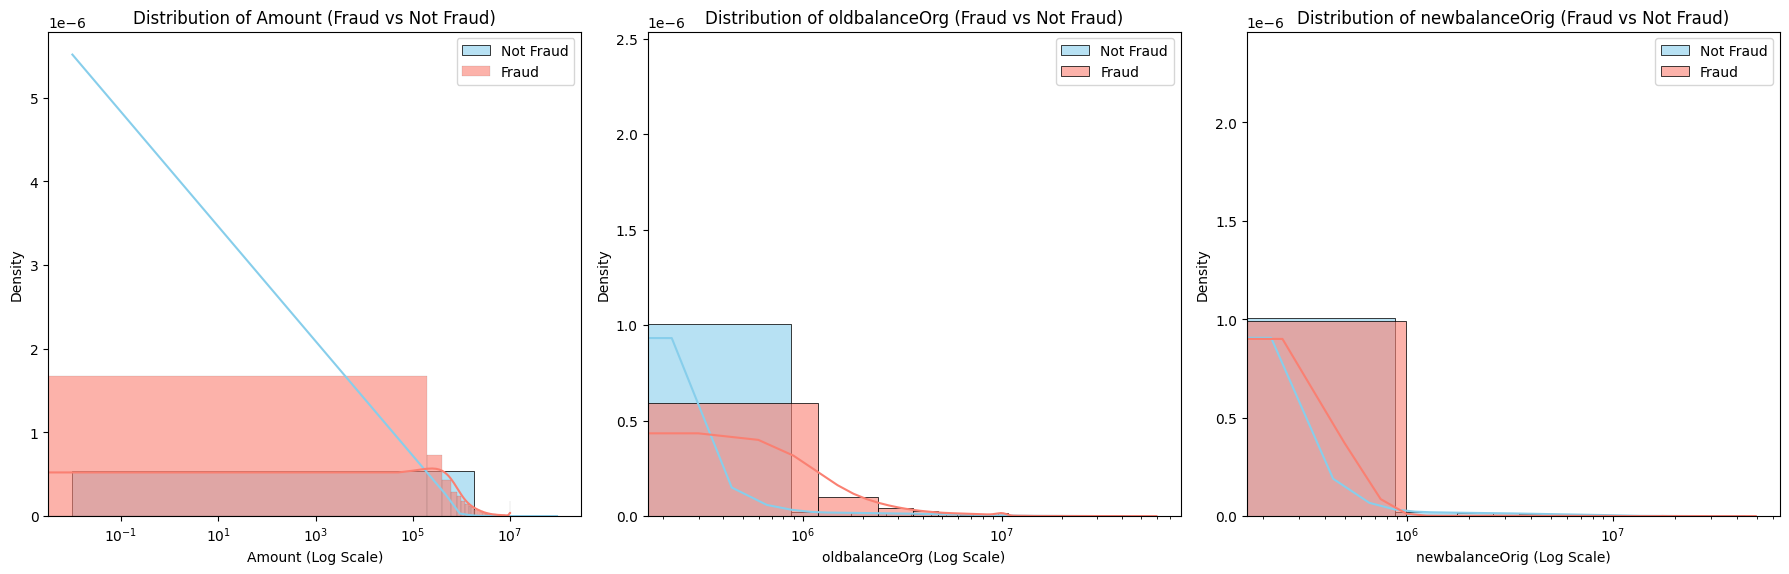

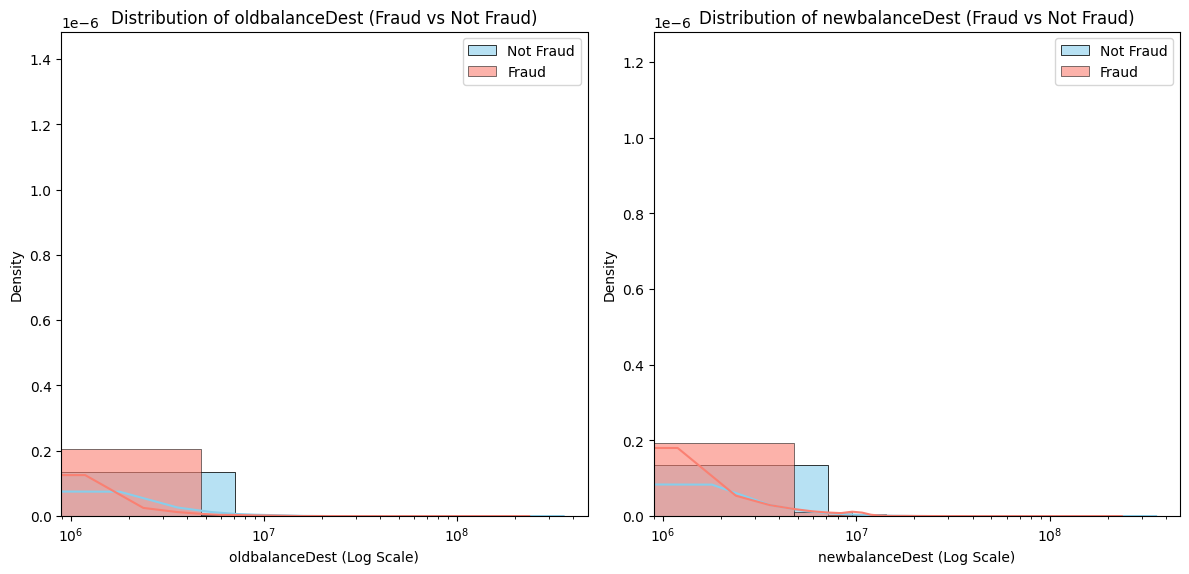

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' DataFrame is already loaded from the previous step.

print("\n--- Phase 2: Data Cleaning & Feature Engineering (Part 1) ---")
print("\n--- Addressing Balance Inconsistencies & Specific Zero-Balance Patterns ---")

# 1. Feature: orig_balance_error
# This checks if newbalanceOrig + amount - oldbalanceOrg is not zero.
# Ideally, for an outgoing transaction (e.g., PAYMENT, CASH_OUT, TRANSFER, DEBIT),
# oldbalanceOrg - amount should equal newbalanceOrig.
# So, newbalanceOrig - (oldbalanceOrg - amount) = 0 => newbalanceOrig - oldbalanceOrg + amount = 0.
df['orig_balance_error'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']

# 2. Feature: dest_balance_error
# This is for the destination account. For 'TRANSFER' and 'CASH_IN' types,
# the amount is added to the destination balance.
# For other types (PAYMENT, CASH_OUT, DEBIT), the balance behavior at destination is different,
# especially for 'M' (Merchant) accounts where balances are always 0.
# We will calculate this error only for 'C' (Customer) destinations, where balance changes are meaningful.
# The expected new balance is oldbalanceDest + amount for incoming transfers/cash-ins.
df['dest_balance_error'] = 0.0 # Initialize with 0

# Mask for transactions where nameDest is a Customer ('C')
c_dest_mask = df['nameDest'].str.startswith('C')

# For 'C' destinations: Calculate error assuming amount is added to destination.
# This generally holds for TRANSFER and CASH_IN where 'C' is recipient.
# For CASH_OUT/DEBIT/PAYMENT to 'C' destination, the oldbalanceDest is typically reduced, but
# in fraud detection, looking for *unexpected* additions or lack of expected additions is also key.
# For now, we'll use the 'expected addition' for 'C' destinations and inspect its utility.
df.loc[c_dest_mask, 'dest_balance_error'] = df.loc[c_dest_mask, 'newbalanceDest'] - \
                                             (df.loc[c_dest_mask, 'oldbalanceDest'] + df.loc[c_dest_mask, 'amount'])


# 3. Binary Flags for Specific Zero-Balance Scenarios (common in fraud)
# These flags help capture cases where balances are zero, which can be suspicious depending on context.

# is_orig_bal_zero_after: New balance of origin account is zero after transaction, but amount was greater than zero.
# Often indicates accounts being emptied.
df['is_orig_bal_zero_after'] = ((df['newbalanceOrig'] == 0) & (df['amount'] > 0)).astype(int)

# is_dest_bal_zero_before: Old balance of destination account was zero before transaction, but amount was greater than zero.
# Can indicate a newly created account for receiving fraudulent funds.
df['is_dest_bal_zero_before'] = ((df['oldbalanceDest'] == 0) & (df['amount'] > 0)).astype(int)

# is_orig_bal_zero_before: Old balance of origin account was zero.
df['is_orig_bal_zero_before'] = (df['oldbalanceOrg'] == 0).astype(int)

# is_dest_bal_zero_after: New balance of destination account is zero.
df['is_dest_bal_zero_after'] = (df['newbalanceDest'] == 0).astype(int)


print("\n--- Checking Newly Created Balance-Related Features ---")

print("\n'orig_balance_error' descriptive statistics:")
print(df['orig_balance_error'].describe())
print("\n'dest_balance_error' descriptive statistics (for Customer Destinations only):")
# Filter for 'C' destinations to get meaningful stats, as 'M' destinations have 0 for old/new balanceDest.
print(df[c_dest_mask]['dest_balance_error'].describe())

print("\n--- Distribution of 'orig_balance_error' for Fraudulent vs Non-Fraudulent Transactions ---")
print(df.groupby('isFraud')['orig_balance_error'].describe())

print("\n--- Distribution of 'dest_balance_error' for Fraudulent vs Non-Fraudulent (Customer Destinations only) ---")
print(df[c_dest_mask].groupby('isFraud')['dest_balance_error'].describe())

print("\n--- Value Counts for Zero-Balance Flags (Fraud vs Non-Fraud) ---")
print("\n'is_orig_bal_zero_after' distribution by isFraud:")
print(df.groupby('isFraud')['is_orig_bal_zero_after'].value_counts(normalize=True))

print("\n'is_dest_bal_zero_before' distribution by isFraud:")
print(df.groupby('isFraud')['is_dest_bal_zero_before'].value_counts(normalize=True))

print("\n'is_orig_bal_zero_before' distribution by isFraud:")
print(df.groupby('isFraud')['is_orig_bal_zero_before'].value_counts(normalize=True))

print("\n'is_dest_bal_zero_after' distribution by isFraud:")
print(df.groupby('isFraud')['is_dest_bal_zero_after'].value_counts(normalize=True))


print("\n--- Visualizing Key Numerical Features (Log Scale) for Fraud vs Non-Fraud ---")

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(df[df['isFraud'] == 0]['amount'], bins=50, color='skyblue', kde=True, stat='density', alpha=0.6, label='Not Fraud')
sns.histplot(df[df['isFraud'] == 1]['amount'], bins=50, color='salmon', kde=True, stat='density', alpha=0.6, label='Fraud')
plt.title('Distribution of Amount (Fraud vs Not Fraud)')
plt.xscale('log') # Use log scale due to high range and to see details in smaller values
plt.xlabel('Amount (Log Scale)')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 3, 2)
sns.histplot(df[df['isFraud'] == 0]['oldbalanceOrg'], bins=50, color='skyblue', kde=True, stat='density', alpha=0.6, label='Not Fraud')
sns.histplot(df[df['isFraud'] == 1]['oldbalanceOrg'], bins=50, color='salmon', kde=True, stat='density', alpha=0.6, label='Fraud')
plt.title('Distribution of oldbalanceOrg (Fraud vs Not Fraud)')
plt.xscale('log')
plt.xlabel('oldbalanceOrg (Log Scale)')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 3, 3)
sns.histplot(df[df['isFraud'] == 0]['newbalanceOrig'], bins=50, color='skyblue', kde=True, stat='density', alpha=0.6, label='Not Fraud')
sns.histplot(df[df['isFraud'] == 1]['newbalanceOrig'], bins=50, color='salmon', kde=True, stat='density', alpha=0.6, label='Fraud')
plt.title('Distribution of newbalanceOrig (Fraud vs Not Fraud)')
plt.xscale('log')
plt.xlabel('newbalanceOrig (Log Scale)')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df[df['isFraud'] == 0]['oldbalanceDest'], bins=50, color='skyblue', kde=True, stat='density', alpha=0.6, label='Not Fraud')
sns.histplot(df[df['isFraud'] == 1]['oldbalanceDest'], bins=50, color='salmon', kde=True, stat='density', alpha=0.6, label='Fraud')
plt.title('Distribution of oldbalanceDest (Fraud vs Not Fraud)')
plt.xscale('log')
plt.xlabel('oldbalanceDest (Log Scale)')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df[df['isFraud'] == 0]['newbalanceDest'], bins=50, color='skyblue', kde=True, stat='density', alpha=0.6, label='Not Fraud')
sns.histplot(df[df['isFraud'] == 1]['newbalanceDest'], bins=50, color='salmon', kde=True, stat='density', alpha=0.6, label='Fraud')
plt.title('Distribution of newbalanceDest (Fraud vs Not Fraud)')
plt.xscale('log')
plt.xlabel('newbalanceDest (Log Scale)')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
import pandas as pd

# Assuming 'df' DataFrame is available from your initial data loading and feature engineering steps

print("\n--- Removing Data Leakage Features ---")

features_to_drop = [
    'newbalanceOrig',
    'newbalanceDest',
    'orig_balance_error',
    'dest_balance_error'
]

# Ensure features exist before dropping to prevent errors
existing_features_to_drop = [f for f in features_to_drop if f in df.columns]

if existing_features_to_drop:
    df = df.drop(columns=existing_features_to_drop)
    print(f"Successfully dropped leakage features: {existing_features_to_drop}")
    print(f"New DataFrame shape: {df.shape}")
else:
    print("No leakage features found to drop, or they were already removed.")


print("\n--- Next Steps ---")
print("Now that the leaky features are removed, we need to re-run the subsequent phases.")
print("1. **Re-run Phase 3: Model Preparation and Training**")
print("2. **Re-run Phase 4: Model Evaluation**")
print("This will train and evaluate the model on a cleaned dataset, giving us more realistic performance metrics.")


--- Removing Data Leakage Features ---
Successfully dropped leakage features: ['newbalanceOrig', 'newbalanceDest', 'orig_balance_error', 'dest_balance_error']
New DataFrame shape: (6362620, 15)

--- Next Steps ---
Now that the leaky features are removed, we need to re-run the subsequent phases.
1. **Re-run Phase 3: Model Preparation and Training**
2. **Re-run Phase 4: Model Evaluation**
This will train and evaluate the model on a cleaned dataset, giving us more realistic performance metrics.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler # Changed from over_sampling.SMOTE
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix
import time # Import time for measuring execution

# --- IMPORTANT: Ensure LightGBM is installed with GPU support ---
# In a new Colab session, you might need to run this first (uncomment if necessary):
# !pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

# Check if the GPU environment is ready (optional, but good for debugging)
try:
    _ = lgb.LGBMClassifier(device='gpu')
    print("LightGBM can detect GPU. Proceeding with GPU training.")
except lgb.basic.LightGBMError as e:
    print(f"LightGBM GPU support not detected or configured correctly: {e}")
    print("Falling back to CPU training. Consider reinstalling lightgbm with GPU options or checking CUDA setup.")
    # You might want to exit here if GPU is mandatory, or continue with CPU if acceptable.


# Assuming 'df' DataFrame is already loaded and updated from the previous steps
# This code block is a repeat of the previous one, with the crucial 'device='gpu'' addition.

print("\n--- Phase 3: Model Preparation and Training (Revised Imbalance Handling & GPU acceleration) ---")

# Define features (X) and target (y)
X = df.drop('isFraud', axis=1)
y = df['isFraud']

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")


# Time-based Train-Test Split
# Using day_of_simulation for a more realistic split (train on earlier data, test on later data).
train_days_threshold = 25 # Days 0 to 24 for training, Days 25 to 30 for testing

X_train_time = X[X['day_of_simulation'] < train_days_threshold]
y_train_time = y[X['day_of_simulation'] < train_days_threshold]

X_test_time = X[X['day_of_simulation'] >= train_days_threshold]
y_test_time = y[X['day_of_simulation'] >= train_days_threshold]

print(f"\nTrain set shape (time-based): X_train_time={X_train_time.shape}, y_train_time={y_train_time.shape}")
print(f"Test set shape (time-based): X_test_time={X_test_time.shape}, y_test_time={y_test_time.shape}")

print("\n--- Handling Class Imbalance with RandomUnderSampler ---")
# Apply RandomUnderSampler only on the training data.
# This will significantly reduce the training set size by undersampling the majority class.
# We aim for a 1:1 ratio between the majority and minority classes.
rus = RandomUnderSampler(random_state=42, sampling_strategy='auto') # 'auto' will balance to 1:1 ratio
print("Applying RandomUnderSampler... This will significantly reduce dataset size.")
X_res, y_res = rus.fit_resample(X_train_time, y_train_time)

print(f"Shape of training data after RandomUnderSampler: X_res={X_res.shape}, y_res={y_res.shape}")
print(f"Class distribution after RandomUnderSampler (y_res):\n{y_res.value_counts()}")


print("\n--- Training LightGBM Model ---")
# Initialize LightGBM Classifier with GPU acceleration enabled
# is_unbalance=True can still be beneficial even with balanced data from sampling
lgbm = lgb.LGBMClassifier(objective='binary',
                          metric='auc',
                          is_unbalance=True, # Helps with imbalanced data, even after resampling
                          n_estimators=1000,
                          learning_rate=0.05,
                          num_leaves=31,
                          max_depth=-1,
                          min_child_samples=20,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          random_state=42,
                          n_jobs=-1,
                          **{'device': 'gpu'} # *** Still crucial for GPU utilization ***
                         )

print("Training LightGBM model with GPU (on undersampled data)... This should be much faster and avoid crashes.")
start_time = time.time()
lgbm.fit(X_res, y_res)
end_time = time.time()
print(f"LightGBM model training complete in {end_time - start_time:.2f} seconds!")

LightGBM can detect GPU. Proceeding with GPU training.

--- Phase 3: Model Preparation and Training (Revised Imbalance Handling & GPU acceleration) ---

Features (X) shape: (6362620, 14)
Target (y) shape: (6362620,)

Train set shape (time-based): X_train_time=(6259029, 14), y_train_time=(6259029,)
Test set shape (time-based): X_test_time=(103591, 14), y_test_time=(103591,)

--- Handling Class Imbalance with RandomUnderSampler ---
Applying RandomUnderSampler... This will significantly reduce dataset size.
Shape of training data after RandomUnderSampler: X_res=(13190, 14), y_res=(13190,)
Class distribution after RandomUnderSampler (y_res):
isFraud
0    6595
1    6595
Name: count, dtype: int64

--- Training LightGBM Model ---
Training LightGBM model with GPU (on undersampled data)... This should be much faster and avoid crashes.
[LightGBM] [Info] Number of positive: 6595, number of negative: 6595
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info


--- Phase 4: Model Evaluation ---

--- Making Predictions on the Test Set ---

--- Model Performance Metrics ---

Classification Report (Default Threshold 0.5):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    101973
           1       0.65      1.00      0.79      1618

    accuracy                           0.99    103591
   macro avg       0.83      1.00      0.89    103591
weighted avg       0.99      0.99      0.99    103591


ROC AUC Score: 0.9997

Confusion Matrix (Default Threshold 0.5):
[[101105    868]
 [     0   1618]]


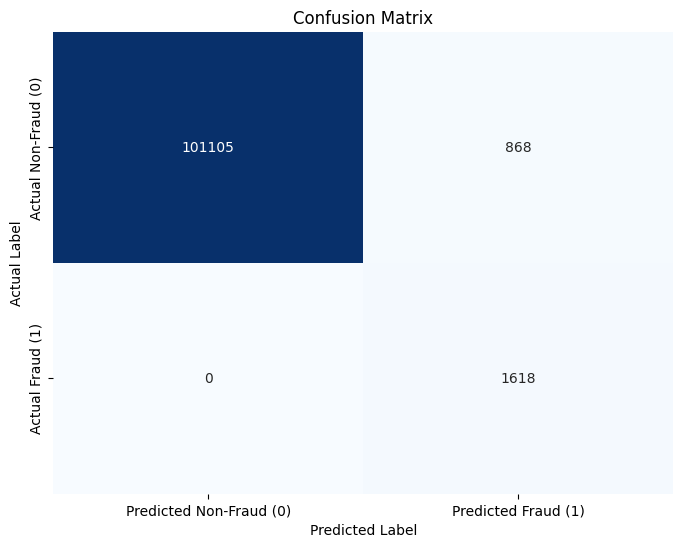


--- Feature Importance Analysis ---

Top 20 Most Important Features:
                    Feature  Importance
0                    amount        7823
1             oldbalanceOrg        6987
2            oldbalanceDest        4890
9         day_of_simulation        3461
8               hour_of_day        3322
4    is_orig_bal_zero_after         661
6   is_orig_bal_zero_before         546
10            type_CASH_OUT         476
13            type_TRANSFER         432
7    is_dest_bal_zero_after         303
12             type_PAYMENT         260
5   is_dest_bal_zero_before         254
11               type_DEBIT          50
3            isFlaggedFraud           0


/tmp/ipython-input-21-3116265478.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')


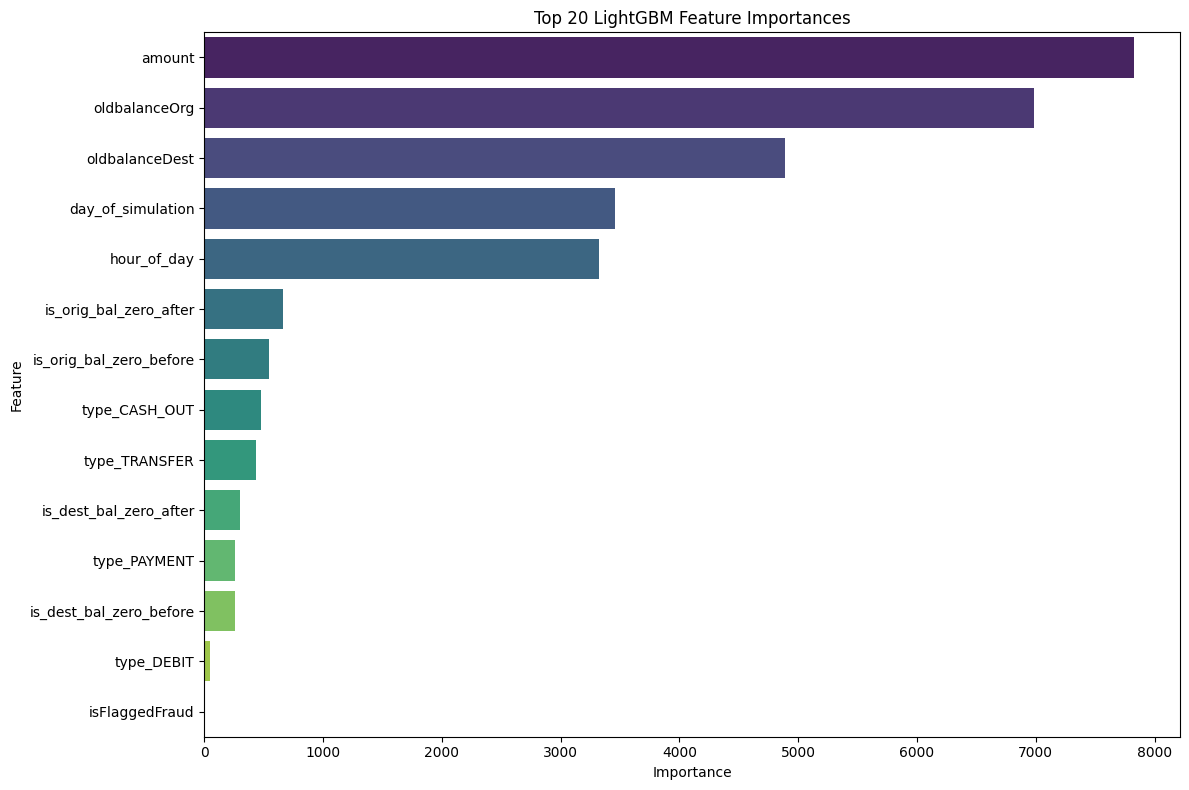


--- Next Steps: Interpretation and Actionable Insights ---
We will now interpret these results to understand the model's performance and identify key factors for fraud.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import lightgbm as lgb # Ensuring lightgbm is explicitly imported here

# Assuming 'lgbm' model is already trained from the previous step
# Assuming 'X_test_time' and 'y_test_time' are available from the previous step

print("\n--- Phase 4: Model Evaluation ---")

print("\n--- Making Predictions on the Test Set ---")
# Predict probabilities for the positive class (isFraud=1)
y_pred_proba = lgbm.predict_proba(X_test_time)[:, 1]

# Predict class labels using the default threshold (0.5)
y_pred = lgbm.predict(X_test_time)

print("\n--- Model Performance Metrics ---")

# Classification Report
# This gives Precision, Recall, F1-score for both classes
print("\nClassification Report (Default Threshold 0.5):")
print(classification_report(y_test_time, y_pred))

# ROC AUC Score
# ROC AUC is a good metric for imbalanced datasets, but Precision-Recall AUC is often better for highly imbalanced cases
roc_auc = roc_auc_score(y_test_time, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
print("\nConfusion Matrix (Default Threshold 0.5):")
cm = confusion_matrix(y_test_time, y_pred)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-Fraud (0)', 'Predicted Fraud (1)'],
            yticklabels=['Actual Non-Fraud (0)', 'Actual Fraud (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print("\n--- Feature Importance Analysis ---")

# Get feature importances from the trained LightGBM model
feature_importances = lgbm.feature_importances_
feature_names = X_test_time.columns # Use column names from the test set features

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print top N features
print("\nTop 20 Most Important Features:")
print(importance_df.head(20))

# Visualize Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
plt.title('Top 20 LightGBM Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\n--- Next Steps: Interpretation and Actionable Insights ---")
print("We will now interpret these results to understand the model's performance and identify key factors for fraud.")

In [22]:
import pickle
import os

# Define the directory where you want to save the model
# It's good practice to create a 'models' directory or similar
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True) # Create the directory if it doesn't exist

# Define the file path for the saved model
model_path = os.path.join(model_dir, 'lgbm_fraud_model.pkl')

print(f"Saving the LightGBM model to: {model_path}")

try:
    with open(model_path, 'wb') as file:
        pickle.dump(lgbm, file) # 'lgbm' is your trained model object from Phase 3
    print("LightGBM model saved successfully!")
except Exception as e:
    print(f"Error saving model: {e}")

print("\n--- Next Steps for Streamlit Deployment ---")
print("Once the model is saved, we will create the Streamlit application file and prepare for GitHub deployment.")

Saving the LightGBM model to: models/lgbm_fraud_model.pkl
LightGBM model saved successfully!

--- Next Steps for Streamlit Deployment ---
Once the model is saved, we will create the Streamlit application file and prepare for GitHub deployment.


In [24]:
!pip install streamlit pandas numpy lightgbm scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 129.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.6 MB/s eta 0:00:00


In [32]:
%%writefile streamlit_app.py
import streamlit as st
import pandas as pd
import numpy as np
import pickle
import os

# --- 1. Load the Trained Model ---
# Define the path to your saved model relative to the Streamlit app script
model_dir = 'models' # Assuming 'models' directory is at the same level as your streamlit_app.py
model_path = os.path.join(model_dir, 'lgbm_fraud_model.pkl')

try:
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
    st.success("Model loaded successfully!")
except FileNotFoundError:
    st.error(f"Error: Model file not found at {model_path}. Make sure 'models' directory and 'lgbm_fraud_model.pkl' exist.")
    st.stop() # Stop the app if the model cannot be loaded
except Exception as e:
    st.error(f"Error loading model: {e}")
    st.stop()

# --- 2. Streamlit App Title and Description ---
st.set_page_config(page_title="Fraud Detection App", layout="centered")
st.title("💸 Online Payment Fraud Detection")
st.markdown("Enter transaction details to predict if it's a fraudulent activity.")

# --- 3. User Input Features ---
st.header("Transaction Details")

st.subheader("General Transaction Info")
amount = st.number_input("Transaction Amount ($)", min_value=0.01, value=1000.00, step=100.0)
oldbalanceOrg = st.number_input("Old Balance Originator ($)", min_value=0.0, value=50000.0, step=1000.0)
oldbalanceDest = st.number_input("Old Balance Destination ($)", min_value=0.0, value=10000.0, step=1000.0)
# isFlaggedFraud removed from UI, as it was not a training feature
day_of_simulation = st.slider("Day of Simulation (1-30)", min_value=1, max_value=30, value=15)
hour_of_day = st.slider("Hour of Day (0-23)", min_value=0, max_value=23, value=12)

st.subheader("Balance Status Indicators")
is_orig_bal_zero_before = st.checkbox("Originator Balance Zero Before Transaction", value=False)
is_orig_bal_zero_after = st.checkbox("Originator Balance Zero After Transaction", value=False)
is_dest_bal_zero_before = st.checkbox("Destination Balance Zero Before Transaction", value=False)
is_dest_bal_zero_after = st.checkbox("Destination Balance Zero After Transaction", value=False)

st.subheader("Transaction Type")
transaction_type = st.radio(
    "Select Transaction Type:",
    ('CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER')
)

# --- 4. Prepare Features for Prediction ---
def preprocess_inputs(amount, oldbalanceOrg, oldbalanceDest,
                      is_orig_bal_zero_before, is_orig_bal_zero_after,
                      is_dest_bal_zero_before, is_dest_bal_zero_after,
                      hour_of_day, day_of_simulation,
                      transaction_type):

    # Create a dictionary to hold the features
    features = {
        'amount': amount,
        'oldbalanceOrg': oldbalanceOrg,
        'oldbalanceDest': oldbalanceDest,
        'hour_of_day': hour_of_day,
        'day_of_simulation': day_of_simulation,
        'is_orig_bal_zero_before': 1 if is_orig_bal_zero_before else 0,
        'is_orig_bal_zero_after': 1 if is_orig_bal_zero_after else 0,
        'is_dest_bal_zero_before': 1 if is_dest_bal_zero_before else 0,
        'is_dest_bal_zero_after': 1 if is_dest_bal_zero_after else 0,
        'type_CASH_IN': 0,
        'type_CASH_OUT': 0,
        'type_DEBIT': 0,
        'type_PAYMENT': 0,
        'type_TRANSFER': 0
    }

    # Set the one-hot encoded type based on user selection
    features[f'type_{transaction_type}'] = 1

    # Define the exact 14 features in the order expected by the trained model
    feature_order = [
        'amount',
        'oldbalanceOrg',
        'oldbalanceDest',
        'hour_of_day',
        'day_of_simulation',
        'is_orig_bal_zero_before',
        'is_orig_bal_zero_after',
        'is_dest_bal_zero_before',
        'is_dest_bal_zero_after',
        'type_CASH_IN',
        'type_CASH_OUT',
        'type_DEBIT',
        'type_PAYMENT',
        'type_TRANSFER'
    ]

    # Convert to DataFrame in the correct order
    input_df = pd.DataFrame([features])[feature_order]

    return input_df

# --- 5. Make Prediction ---
if st.button("Predict Fraud"):
    input_df = preprocess_inputs(
        amount, oldbalanceOrg, oldbalanceDest,
        is_orig_bal_zero_before, is_orig_bal_zero_after,
        is_dest_bal_zero_before, is_dest_bal_zero_after,
        hour_of_day, day_of_simulation,
        transaction_type
    )

    prediction_proba = model.predict_proba(input_df)[:, 1] # Probability of being class 1 (fraud)
    prediction = (prediction_proba > 0.5).astype(int) # Default threshold 0.5

    st.subheader("Prediction Result:")
    if prediction[0] == 1:
        st.error(f"⚠️ **This transaction is predicted as FRAUDULENT!**")
    else:
        st.success("✅ This transaction is predicted as LEGITIMATE.")

    st.write(f"Confidence Score (Probability of Fraud): **{prediction_proba[0]:.4f}**")
    st.write("---")
    st.markdown("Disclaimer: This is a predictive model based on historical data and should be used as an assistive tool.")

Overwriting streamlit_app.py
